In [28]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import sympy as sp
import scipy as sc
import scipy.signal as signal
from   datetime import datetime, timedelta
import statsmodels.api as sm
import os
import matplotlib as mpl
import glob
import statsmodels.api as sm
from scipy.optimize import curve_fit
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime
from os.path import dirname, join as pjoin
import scipy.io as sio
from matplotlib import cm
import glob
import matplotlib.dates as mdates
from windrose import WindroseAxes
from windrose import WindAxes
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib import font_manager as fm
import cdsapi
from netCDF4 import Dataset, num2date
from pytz import timezone
import pytz
from pyproj import Proj
plt.style.use('default')

In [29]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [30]:
# Funiciones 
def roundBy(x, base=10):
    return int(base * round(float(x)/base))

def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return lon, lat

In [31]:
def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)

    return ind

In [32]:
# --------------****Alineación archivos txt****************-----------
# nombre="Stack"
# apellido="Overflow"

# #alinear centro:
# print('< {:^20} >'.format(nombre))
# print(f'< {apellido:^20} >')

# #alinear izquierda
# print('< {:<20} >'.format(nombre))
# print(f'< {apellido:<20} >')

# #alinear derecha
# print('< {:>20} >'.format(nombre))
# print(f'< {apellido:>20} >')

# #opcion 1
# print(f'< {nombre:<10} {apellido:>10} >')
# #opcion 2
# print('< {:<10} {:>10} >'.format(nombre,apellido))

In [33]:
# # Exportar Kml para cambiar coordenadas a utm
# from simplekml import Kml
# # Cord = np.c_[lon, lat]
# kml = Kml(name ='Boundary_Points')
# for i in range (0, Cord.shape[0]):
#     kml.newpoint(name='BP'+str(i+1), coords = [Cord[i]])
# # print (kml.kml())
# kml.save("Boundary_Points.kml")

In [34]:
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN BASE

## Lectura de batimetria

In [35]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_200m"
# data_bat = pd.read_csv (path+'\Bat2SAI.xyz',delimiter='\s+',encoding = 'cp1252',header=None,\
#                    names = ["x","y","z"])

In [36]:
## Lecutra de la batimetría
#-------------------------------------
delta = 200                                           # Tamaño de la grilla 
x = np.array ([404758.9787 + i*delta for i in range(203)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1368354.4849 + i*delta for i in range (208)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\idw_200m.txt',skip_header = 6))
z[z == -9999] = np.nan # Z donde es tierra

kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()

In [37]:
print(np.nanmin(x_new), np.nanmin(y_new) )
print(np.nanmax(x_new), np.nanmax(y_new) )

404758.9787 1368354.4849
445158.9787 1409754.4849


In [38]:
print(np.nanmin(x_new), np.nanmin(y_new)+1000)

404758.9787 1369354.4849


In [39]:
1369354.4849+13000*2

1395354.4849

In [40]:
np.nanmin(x_new)

404758.9787

In [41]:
411053.13910183974+22300

433353.13910183974

In [42]:
lon_min, lat_min = coord_wgs (np.nanmin(x_new),np.nanmin(y_new))
print(360+lon_min, lat_min)

lon_max, lat_max = coord_wgs (np.nanmax(x_new),np.nanmax(y_new))
print(360+lon_max, lat_max)



278.12389429615087 12.376604643559318
278.49478255337556 12.751914259554704


## Lectura de linea de costa

In [43]:
data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
mat_fname = pjoin(data_dir, 'linea_Costa.mat')     # Econtrar el archivo
data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
Variables = sorted(data_mat.keys())               # Variables ordenadas Alfa-numericamente 
Variables
xlc = np.array(data_mat['data'][0][0][0])
ylc = np.array(data_mat['data'][0][0][1])
lc=np.column_stack((xlc,ylc))

## Figura Batimetria

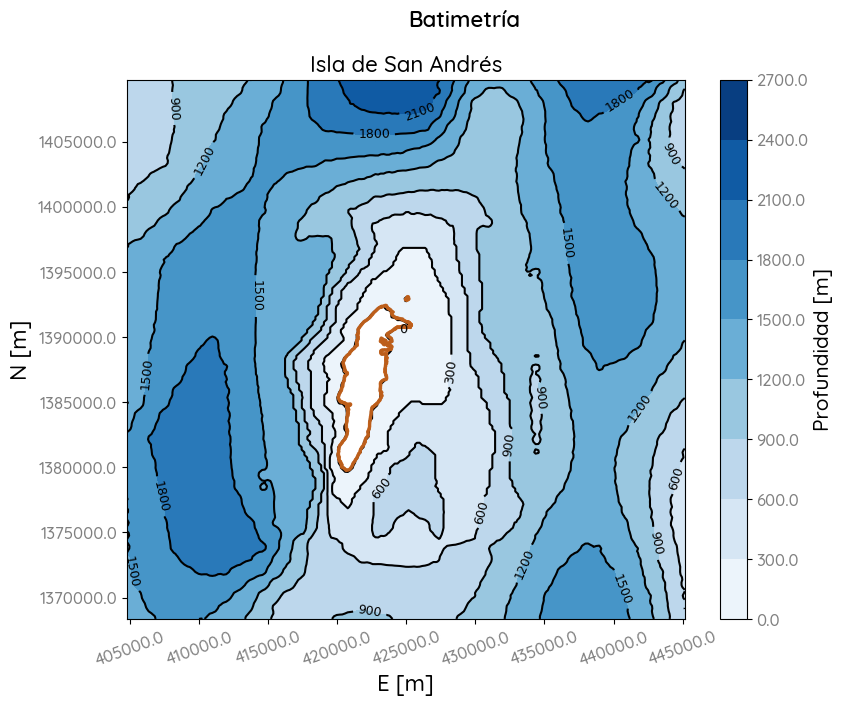

In [44]:
fig, ax = plt.subplots(figsize = (9,7))
colormap = cm.coolwarm
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(0,3000,300),cmap='Blues')
cb=plt.colorbar(pc)
# a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(0,3000,300)),colors="rosybrown",\
#                linewidths=1.5)
a = ax.contour(x_new, y_new, z_new,colors="k",levels=list(np.arange(0,3000,300)),\
                linewidths=1.5)
label = plt.clabel(a, fontsize=9, inline=1, fmt = '%1.0f', colors="k")
# plt.clabel(a, fontsize=9, inline=1,fmt='%2.1f',colors='k')
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
ax.plot(lc[:,0], lc[:,1], "-k", lw=2)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Profundidad [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
fig.suptitle("Batimetría", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Isla de San Andrés',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# Cunado los xticklabels son fechas:
# for label in ax.get_xticklabels():
#     label.set_fontproperties(prop_1)
#     label.set_color('gray')
#     label.set_size(12)
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9)
# ax.set_title('Localización: 81.500°W - 12.670°N',size = 18)
# ax.legend(loc = 4)
# ax.set_xticks(rotation=30)
plt.xticks(rotation = 20)
plt.grid(False)

# PUNTOS DE OBSERVACIÓN

## Cove

In [46]:
lat_cove = 12.555738
lon_cove = -81.738463
x_cove, y_cove = proj_ZONE17(lon_cove,lat_cove)
ind_xcove = min_ind(value=x_cove, vector=x_new, delta= delta)
ind_ycove = min_ind(value=y_cove, vector=y_new, delta= delta)
list_cove = ['Cove',ind_xcove,ind_ycove]

Indice: 76 , Valor: 419958.9787 , Valor real: 419777.9967201181
Indice: 99 , Valor: 1388154.4849 , Valor real: 1388119.6799451713


## Barrera

In [47]:
lat_barrera =  12.603483
lon_barrera = -81.678766
x_barrera, y_barrera = proj_ZONE17(lon_barrera,lat_barrera)
ind_xbarrera = min_ind(value=x_barrera, vector=x_new, delta= delta)
ind_ybarrera = min_ind(value=y_barrera, vector=y_new, delta= delta)
list_barrera = ['Barrera',ind_xbarrera,ind_ybarrera]

Indice: 108 , Valor: 426358.9787 , Valor real: 426277.01849166275
Indice: 126 , Valor: 1393554.4849 , Valor real: 1393382.35178034


## Nesting

In [20]:
Nest_X = [414707.35, 420440.70, 426174.04, 431907.375]
Nest_Y = [1377008.875, 1383308.875, 1389608.875, 1395908.875]
ind_nest_X, ind_nest_Y = np.zeros(4), np.zeros(4)
k = 0 
for i, j in zip (Nest_X, Nest_Y):
    ind_nest_X[k] = min_ind(value=i, vector=x_new, delta=delta)
    ind_nest_Y[k] = min_ind(value=j, vector=y_new, delta=delta)
    k=k+1

Dic_nest = {}
ind_xn = []
ind_yn = []
lis_names = []

# Puntos en la frontera norte
for i in range (len(ind_nest_X)):
    ind_xn.append(ind_nest_X[i])
    ind_yn.append(ind_nest_Y[3])
    lis_names.append('N'+str(i+1))

# Puntos en la frontera sur
for i in range (len(ind_nest_X)):
    ind_xn.append(ind_nest_X[i])
    ind_yn.append(ind_nest_Y[0])
    lis_names.append('S'+str(i+1))

# Puntos en la frontera oeste
for i in range (len(ind_nest_Y)):
    ind_xn.append(ind_nest_X[0])
    ind_yn.append(ind_nest_Y[i])
    lis_names.append('W'+str(i+1))

# Puntos en la frontera este
for i in range (len(ind_nest_Y)):
    ind_xn.append(ind_nest_X[3])
    ind_yn.append(ind_nest_Y[i])
    lis_names.append('E'+str(i+1))


Dic_nest.update({'ID':lis_names, 'Ind_X':ind_xn, 'Ind_Y':ind_yn})

df_nest = pd.DataFrame(Dic_nest)

df_nest

Indice: 50 , Valor: 414758.9787 , Valor real: 414707.35
Indice: 44 , Valor: 1377154.4849 , Valor real: 1377008.875
Indice: 79 , Valor: 420558.9787 , Valor real: 420440.7
Indice: 75 , Valor: 1383354.4849 , Valor real: 1383308.875
Indice: 108 , Valor: 426358.9787 , Valor real: 426174.04
Indice: 107 , Valor: 1389754.4849 , Valor real: 1389608.875
Indice: 136 , Valor: 431958.9787 , Valor real: 431907.375
Indice: 138 , Valor: 1395954.4849 , Valor real: 1395908.875


,ID,Ind_X,Ind_Y
0,N1,50.0,138.0
1,N2,79.0,138.0
2,N3,108.0,138.0
3,N4,136.0,138.0
4,S1,50.0,44.0
5,S2,79.0,44.0
6,S3,108.0,44.0
7,S4,136.0,44.0
8,W1,50.0,44.0
9,W2,50.0,75.0


## Puntos de salinidad y temperatura 

In [21]:
df_perfiles = pd.read_csv('Coordenas_Perfiles_2.csv')
df_perfiles.drop('Unnamed: 0',axis=1, inplace=True)
df_perfiles.head(4)

,lon,lat,x,y
0,-81.681931,12.613034,425936.041428,1.394440e+06
1,-81.683103,12.612860,425808.652328,1.394421e+06
2,-81.670524,12.598765,427170.946786,1.392858e+06
3,-81.667462,12.579662,427498.186824,1.390745e+06


In [22]:
in_ts_x = np.zeros(len(df_perfiles['x']))
in_ts_y = np.zeros(len(df_perfiles['y']))
k = 0
for i, j in zip (df_perfiles['x'],df_perfiles['y']):
    in_ts_x[k] = min_ind(value=i, vector=x_new, delta=delta)
    in_ts_y[k] = min_ind(value=j, vector=y_new, delta=delta)
    k = k + 1
ind_name = list('PTS_'+str(i+1) for i in range(len(in_ts_x))) 
df_pts = pd.DataFrame({'ID':ind_name, 'Ind_X':in_ts_x, 'Ind_Y':in_ts_y, 'lon':df_perfiles['lon'],'lat':df_perfiles['lat']})
df_pts.drop_duplicates(subset=['Ind_X', 'Ind_Y'], inplace = True)
df_pts.reset_index(drop=True, inplace=True)

Indice: 106 , Valor: 425958.9787 , Valor real: 425936.0414280868
Indice: 131 , Valor: 1394554.4849 , Valor real: 1394439.5104323549
Indice: 106 , Valor: 425958.9787 , Valor real: 425808.6523279231
Indice: 131 , Valor: 1394554.4849 , Valor real: 1394420.5879379555
Indice: 113 , Valor: 427358.9787 , Valor real: 427170.9467856752
Indice: 123 , Valor: 1392954.4849 , Valor real: 1392858.2999182355
Indice: 114 , Valor: 427558.9787 , Valor real: 427498.1868239869
Indice: 112 , Valor: 1390754.4849 , Valor real: 1390744.8922520124
Indice: 114 , Valor: 427558.9787 , Valor real: 427552.1899286429
Indice: 102 , Valor: 1388754.4849 , Valor real: 1388722.613872698
Indice: 113 , Valor: 427358.9787 , Valor real: 427263.4088631454
Indice: 92 , Valor: 1386754.4849 , Valor real: 1386646.1549718452
Indice: 106 , Valor: 425958.9787 , Valor real: 425807.8723264736
Indice: 86 , Valor: 1385554.4849 , Valor real: 1385424.8331458603
Indice: 96 , Valor: 423958.9787 , Valor real: 423902.1102226691
Indice: 82 , Va

In [23]:
df_plus = pd.DataFrame([list_barrera, list_cove],columns=['ID', 'Ind_X', 'Ind_Y'])
df_ind = pd.concat([df_plus, df_pts[['ID', 'Ind_X', 'Ind_Y']], df_nest], ignore_index=True)
df_ind['Ind_X'] = df_ind['Ind_X'].astype('int') 
df_ind['Ind_Y'] = df_ind['Ind_Y'].astype('int') 

In [24]:
df_ind

,ID,Ind_X,Ind_Y
0,Barrera,108,126
1,Cove,76,99
2,PTS_1,106,131
3,PTS_3,113,123
4,PTS_4,114,112
...,...,...,...
56,W4,50,138
57,E1,136,44
58,E2,136,75
59,E3,136,107


In [25]:
# Guardar archivo con puntos de observación
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
f =open(path+'\PUNTOS_OBS_SAL_TEMP.obs','w')
for i in range (len(df_ind.ID)):
    a = f'{df_ind.iloc[i].ID:<17}'
    b = f'{df_ind.iloc[i].Ind_X:>8}'
    c = f'{df_ind.iloc[i].Ind_Y:>6}'
    print(a+' '+b+' '+c)
    f.write(a+' '+b+' '+c+'\n')
f.close()

Barrera                108    126
Cove                    76     99
PTS_1                  106    131
PTS_3                  113    123
PTS_4                  114    112
PTS_5                  114    102
PTS_6                  113     92
PTS_7                  106     86
PTS_8                   96     82
PTS_9                   92     73
PTS_10                  89     66
PTS_11                  85     56
PTS_12                  77     58
PTS_13                  77     68
PTS_14                  78     79
PTS_15                  76     88
PTS_16                  75     99
PTS_17                  82    109
PTS_18                  88    120
PTS_19                  95    129
PTS_20                  84    109
PTS_21                  83    109
PTS_23                  82    108
PTS_24                  81    108
PTS_25                  79    108
PTS_26                  78    108
PTS_27                  84    111
PTS_28                  82    111
PTS_29                  81    111
PTS_30        

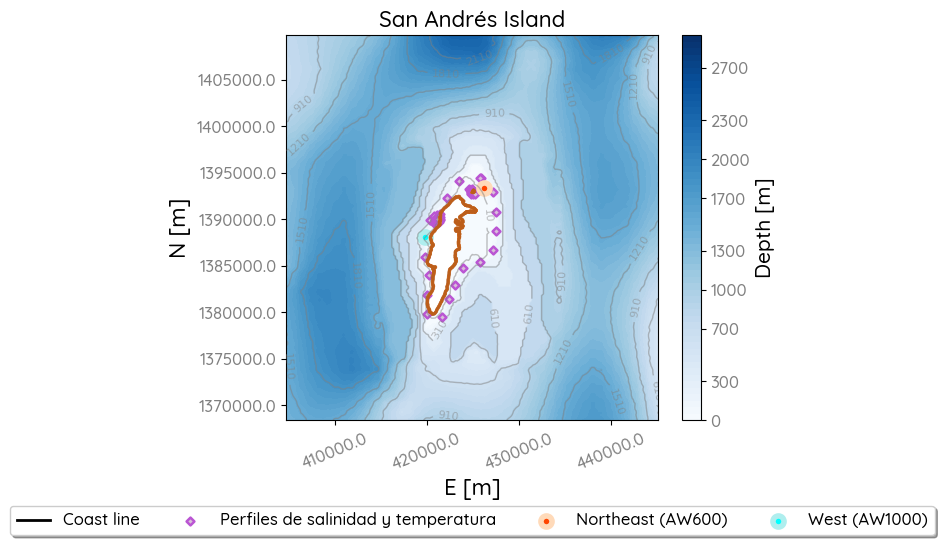

In [26]:
# crear figura
# ------------
fig, ax = plt.subplots(figsize = (6,5))
colormap = cm.YlGnBu
colormap = cm.Blues
level_i = 0
level_f = 3000
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(level_i,level_f,50),cmap=colormap)
cb=plt.colorbar(pc,ticks = list(roundBy(np.linspace(level_i,level_f,10)[i],100) for i in range(10)))
a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(10,3000,300)),colors="gray",\
               linewidths=1,alpha=0.5)
label_fig = ax.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
# plt.clabel(a, fontsize=9, inline=1,fmt='%2.1f',colors='k')
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
ax.plot(lc[:,0], lc[:,1], "-k", lw=2, label = 'Coast line')
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Depth [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
# fig.suptitle("Batimetría", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('San Andrés Island',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# for label in ax.get_xticklabels():
#     label.set_fontproperties(prop_1)
#     label.set_color('gray')
#     label.set_size(12)
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9)
ax.scatter(df_perfiles.x,df_perfiles.y,marker='D',color='mediumorchid',label='Perfiles de salinidad y temperatura',s=4**2\
           ,facecolors= 'thistle',lw=1.8)
ax.scatter(x_barrera,y_barrera,marker='o',color='peachpuff',label='Northeast (AW600)',s=8**2 ,facecolors= 'orangered',lw=4)
ax.scatter(x_cove,y_cove,marker='o',color='paleturquoise',label='West (AW1000)',s=8**2,facecolors= 'cyan',lw=4)
prop1.set_size(12) # Aumentar el tamaño de letra de la leyenda
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation =22.5)
plt.grid(False)

## Condiciones de frontera
<img src="Condiciones_Frontera.png">

# CONDICIONES DE CONTORNO

For modelling the region outside the computational domain, incident waves should be known and are prescribed at the open boundaries. To reduce the reflections at the open boundaries a so-called weakly reflecting boundary condition may be applied. This boundary condition is derived using the Riemann invariants of the linearized shallow water equations without Coriolis and bottom friction (Verboom and Slob, 1984).

$f(t)=U+\zeta\sqrt{\frac{g}{d}}$

where $U$ in m/s is depth-averaged velocity in $x$ or ξ direction, $\zeta$ in m is water level above some horizontal plane of reference (datum),  $d$ an $g$ are depth below some horizontal plane of reference (datum) and acceleration due to gravity in m and m/s respectively.

## Lectura de datos

Caractrísticas de los datos de hycom:

-Resolución espacial: 1/12°

-Resolución temporal:3 horas 

In [27]:
# path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BASES_DE_DATOS\HYCOM_DATA\2021\4_15_nov2021"
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data = Dataset(path+'\Hycom_oct21_nov15_2021_6.nc','r')
# data_surface = Dataset(path+'\hycom_4_15_nov_surface_water_level.nc4')
print(data.variables)
# print('\n')
# print(data_surface)

{'latitude': <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (25,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'longitude': <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: decimal_degrees
unlimited dimensions: 
current shape = (7,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: hours since 2000-01-01 00:00:00
    time_origin: 2000-01-01 00:00:00
    calendar: gregorian
unlimited dimensions: 
current shape = (200,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'depth': <class 'netCDF4._netCDF4.Variable'>
float64 depth(depth)
    units: m
unlimited dimensions: 
current shape = (9,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'water_temp': <class 'netCDF4._netCDF4.Variable'>
float64 water_temp(time, depth, latitude, longitude)
    units: degC


In [28]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
depth = np.array(data.variables['depth'][:]) 
salt = np.array(data.variables['salinity'][:])
salt[salt==-30000] = np.nan
temp = np.array(data.variables['water_temp'][:])
temp[temp==-30000] = np.nan
u = np.array(data.variables['water_u'][:])
u[u==-30000] = np.nan
v = np.array(data.variables['water_v'][:])
v[v==-30000] = np.nan
ws = np.array(data.variables['surf_el'][:])

CPU times: total: 15.6 ms
Wall time: 85.2 ms


In [29]:
depth

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 15., 20.])

In [30]:
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time

array([datetime.datetime(2021, 10, 20, 22, 0),
       datetime.datetime(2021, 10, 21, 1, 0),
       datetime.datetime(2021, 10, 21, 4, 0),
       datetime.datetime(2021, 10, 21, 7, 0),
       datetime.datetime(2021, 10, 21, 10, 0),
       datetime.datetime(2021, 10, 21, 13, 0),
       datetime.datetime(2021, 10, 21, 16, 0),
       datetime.datetime(2021, 10, 21, 19, 0),
       datetime.datetime(2021, 10, 21, 22, 0),
       datetime.datetime(2021, 10, 22, 1, 0),
       datetime.datetime(2021, 10, 22, 4, 0),
       datetime.datetime(2021, 10, 22, 7, 0),
       datetime.datetime(2021, 10, 22, 10, 0),
       datetime.datetime(2021, 10, 22, 13, 0),
       datetime.datetime(2021, 10, 22, 16, 0),
       datetime.datetime(2021, 10, 22, 19, 0),
       datetime.datetime(2021, 10, 22, 22, 0),
       datetime.datetime(2021, 10, 23, 1, 0),
       datetime.datetime(2021, 10, 23, 4, 0),
       datetime.datetime(2021, 10, 23, 7, 0),
       datetime.datetime(2021, 10, 23, 10, 0),
       datetime.dateti

In [31]:
print(lat,'\n'*2,lon)
print('\n'*2,'initial time:',time[0],'\n','end time:',time[-1])

[12.07999992 12.11999989 12.15999985 12.19999981 12.23999977 12.27999973
 12.31999969 12.35999966 12.39999962 12.43999958 12.47999954 12.52000046
 12.56000042 12.60000038 12.64000034 12.68000031 12.72000027 12.76000023
 12.80000019 12.84000015 12.88000011 12.92000008 12.96000004 13.
 13.03999996] 

 [278.08001709 278.16003418 278.23999023 278.32000732 278.40002441
 278.47998047 278.55999756]


 initial time: 2021-10-20 22:00:00 
 end time: 2021-11-14 19:00:00


In [32]:
# Límites de las coordenadas de la batimetría
lat1_bat, lon1_bat =  12.377544, 360-81.877383
lat2_bat, lon2_bat =   12.377544, 360-81.504496
lat3_bat, lon3_bat = 12.751910, 360-81.504496
lat4_bat, lon4_bat = 12.751910, 360-81.877383
print('left down point:',lon1_bat,lat1_bat)
print('rigth down point:', lon2_bat,lat2_bat)
print('rigth upper point:', lon3_bat,lat3_bat)
print('left upper point:', lon4_bat,lat4_bat)

left down point: 278.122617 12.377544
rigth down point: 278.495504 12.377544
rigth upper point: 278.495504 12.75191
left upper point: 278.122617 12.75191


In [33]:
lon1_bat

278.122617

In [34]:
diff_lon2 = []
i_maxlon = []
for j,i in enumerate(lon):
    dif = np.abs(i-lon2_bat)
    print(dif,lon2_bat,i,j)
    diff_lon2.append(dif)
print('\n'*2)
for j,i in enumerate(lon):
    if np.abs(i-lon2_bat)==min(diff_lon2):
        print(min(diff_lon2),lon2_bat,i,j)
        i_maxlon.append(j)
print(min(diff_lon2))
print('\n'*3)

diff_lon1 = []
i_minlon = []
for k,m in enumerate(lon):
    dif = np.abs(m-lon1_bat)
    print(dif,lon1_bat,m,k)
    diff_lon1.append(dif)
print('\n'*2)
for k,m in enumerate(lon):
    if np.abs(m-lon1_bat)==min(diff_lon1):
        print(min(diff_lon1),lon1_bat,m,k)
        i_minlon.append(k)
print(min(diff_lon1))

0.4154869101562326 278.495504 278.08001708984375 0
0.3354698203124826 278.495504 278.1600341796875 1
0.2555137656249826 278.495504 278.239990234375 2
0.17549667578123263 278.495504 278.32000732421875 3
0.09547958593748263 278.495504 278.4000244140625 4
0.015523531249982625 278.495504 278.47998046875 5
0.06449355859376737 278.495504 278.55999755859375 6



0.015523531249982625 278.495504 278.47998046875 5
0.015523531249982625




0.042599910156241094 278.122617 278.08001708984375 0
0.037417179687508906 278.122617 278.1600341796875 1
0.1173732343750089 278.122617 278.239990234375 2
0.1973903242187589 278.122617 278.32000732421875 3
0.2774074140625089 278.122617 278.4000244140625 4
0.3573634687500089 278.122617 278.47998046875 5
0.4373805585937589 278.122617 278.55999755859375 6



0.037417179687508906 278.122617 278.1600341796875 1
0.037417179687508906


In [35]:
del i,j,k,m
diff_lat3 = []
i_maxlat = []
for j,i in enumerate(lat):
    dif = np.abs(i-lat3_bat)
    print(dif,lat3_bat,i,j)
    diff_lat3.append(dif)
print('\n'*2)
for j,i in enumerate(lat):
    if np.abs(i-lat3_bat)==min(diff_lat3):
        print(min(diff_lat3),lat3_bat,i,j)
        i_maxlat.append(j)
print(min(diff_lat3))
print('\n'*3)

diff_lat1=[]
i_minlat = []
for k,m in enumerate(lat):
    dif = np.abs(m-lat1_bat)
    print(dif,lat1_bat,m,k)
    diff_lat1.append(dif)
print('\n'*2)
for k,m in enumerate(lat):
    if np.abs(m-lat1_bat)==min(diff_lat1):
        print(min(diff_lat1),lat1_bat,m,k)
        i_minlat.append(k)
print(min(diff_lat1))

0.6719100762939458 12.75191 12.079999923706055 0
0.6319101144409185 12.75191 12.119999885559082 1
0.5919101525878911 12.75191 12.15999984741211 2
0.5519101907348638 12.75191 12.199999809265137 3
0.5119102288818365 12.75191 12.239999771118164 4
0.4719102670288091 12.75191 12.279999732971191 5
0.4319103051757818 12.75191 12.319999694824219 6
0.39191034332275443 12.75191 12.359999656677246 7
0.3519103814697271 12.75191 12.399999618530273 8
0.31191041961669974 12.75191 12.4399995803833 9
0.2719104577636724 12.75191 12.479999542236328 10
0.23190954223632865 12.75191 12.520000457763672 11
0.1919095803833013 12.75191 12.5600004196167 12
0.15190961853027396 12.75191 12.600000381469727 13
0.11190965667724662 12.75191 12.640000343322754 14
0.07190969482421927 12.75191 12.680000305175781 15
0.03190973297119193 12.75191 12.720000267028809 16
0.008090228881835415 12.75191 12.760000228881836 17
0.04809019073486276 12.75191 12.800000190734863 18
0.0880901525878901 12.75191 12.84000015258789 19
0.1280

In [36]:
print(i_maxlon[0],i_minlon[0],i_maxlat[0]-1,i_minlat[0]+1)

5 1 16 8


In [37]:
# Virficar que las coordenadas queden dentro de los límites máximos de la batimetría
min_lon, ind_min_lon = lon[i_minlon[0]],i_minlon[0]
max_lon, ind_max_lon = lon[i_maxlon[0]],i_maxlon[0]
min_lat, ind_min_lat = lat[i_minlat[0]+1],i_minlat[0]+1
max_lat, ind_max_lat = lat[i_maxlat[0]-1],i_maxlat[0]-1
print('left down point:',min_lon,min_lat)
print('rigth down point:', max_lon,min_lat)
print('rigth upper point:', max_lon,max_lat)
print('left upper point:', min_lon,max_lat)

left down point: 278.1600341796875 12.399999618530273
rigth down point: 278.47998046875 12.399999618530273
rigth upper point: 278.47998046875 12.720000267028809
left upper point: 278.1600341796875 12.720000267028809


In [38]:
Cord = np.zeros(shape=(4,2))
Cord[0] = min_lon-360,min_lat
Cord[1] = max_lon-360,min_lat
Cord[2] = max_lon-360,max_lat
Cord[3] = min_lon-360,max_lat
Cord

array([[-81.83996582,  12.39999962],
       [-81.52001953,  12.39999962],
       [-81.52001953,  12.72000027],
       [-81.83996582,  12.72000027]])

### Cordenadas de HYCOM en UTM

In [39]:
UTMx_bd = np.zeros(shape=(4))
UTMy_bd = np.zeros(shape=(4))
m=0 
for i,j in zip (Cord[:,0]-360,Cord[:,1]):
    UTMx_bd[m], UTMy_bd[m] = proj_ZONE17(i,j)
    m=m+1
print(UTMx_bd,'\n',UTMy_bd)

[408696.12857256 443475.27403179 443545.12067339 408808.96082737] 
 [1370929.16993128 1370840.53050356 1406228.3487373  1406319.12608161]


In [40]:
print('left down point:',np.min(x_new),np.min(y_new))
print('rigth down point:', np.max(x_new),np.min(y_new))
print('left upper point:', np.min(x_new),np.max(y_new))
print('rigth upper point:', np.max(x_new),np.max(y_new))
# print('nrows:',nrows,'\n','ncols:',ncols)

left down point: 404758.9787 1368354.4849
rigth down point: 445158.9787 1368354.4849
left upper point: 404758.9787 1409754.4849
rigth upper point: 445158.9787 1409754.4849


In [41]:
# Traer coordenas en UTM desde Google Earth 
x_bd = np.zeros(shape=(2))
x_bd[0] = UTMx_bd[0]
x_bd[1] = UTMx_bd[1]
y_bd = np.zeros(shape=(2))
y_bd[0] = UTMy_bd[0]
y_bd[1] = UTMy_bd[-1]

In [55]:
X_waves = np.linspace(np.min(X_BD),np.max(X_BD), 4)
Y_waves = np.linspace(np.min(Y_BD),np.max(Y_BD), 4)
xx_waves , yy_waves = np.meshgrid(X_waves, Y_waves)
xx_waves[1:3,1:3] = np.nan
yy_waves[1:3,1:3] = np.nan

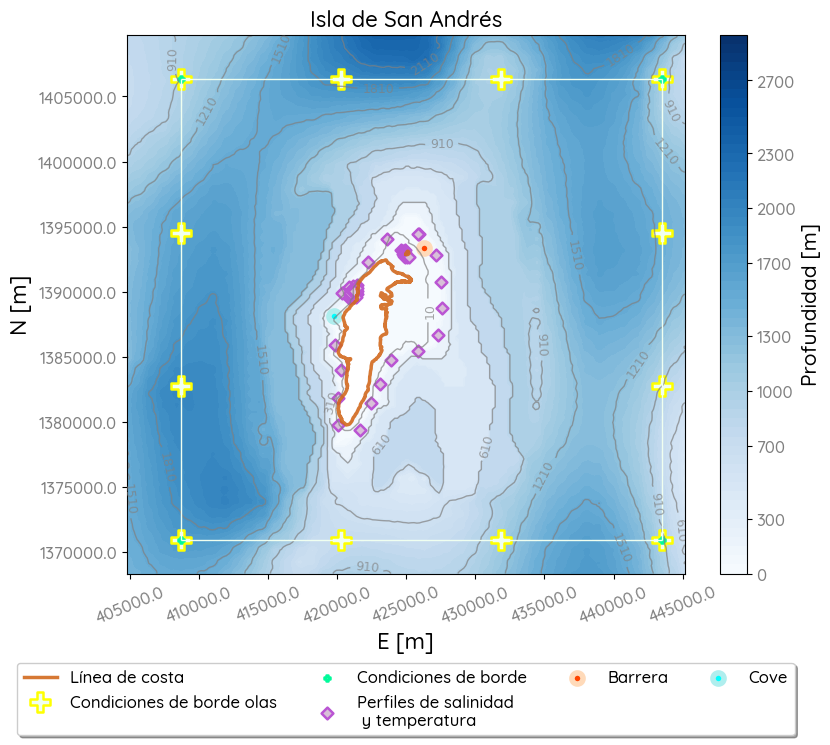

In [57]:
# Figura con todo
X_BD, Y_BD = np.meshgrid(x_bd,y_bd)
# X_control, Y_control = np.meshgrid(x_control, y_control) 
# crear figura
# ------------
fig, ax = plt.subplots(figsize = (9,7))
colormap = cm.YlGnBu
colormap = cm.Blues
level_i = 0
level_f = 3000
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(level_i,level_f,50),cmap=colormap)
cb=plt.colorbar(pc,ticks = list(roundBy(np.linspace(level_i,level_f,10)[i],100) for i in range(10)))
a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(10,3000,300)),colors="gray",\
               linewidths=1,alpha=0.7)
label_fig = ax.clabel(a, fontsize=9, inline=1, fmt = '%1.0f', colors="gray")
# plt.clabel(a, fontsize=9, inline=1,fmt='%2.1f',colors='k')
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Profundidad [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
# fig.suptitle("Batimetría", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Isla de San Andrés',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# for label in ax.get_xticklabels():
#     label.set_fontproperties(prop_1)
#     label.set_color('gray')
#     label.set_size(12)
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9, label = 'Línea de costa')
ax.scatter(xx_waves,yy_waves,marker='P',color='yellow',label='Condiciones de borde olas',s=15**2\
          ,facecolors= 'honeydew',lw=1.8)
ax.scatter(X_BD,Y_BD,marker='P',color='mediumspringgreen',label='Condiciones de borde',s=5**2\
          ,facecolors= 'honeydew',lw=1.8)

# ax.scatter(X_BD,(Y_BD),marker='P',color='mediumspringgreen',label='Condiciones de borde',s=15**2\
#           ,facecolors= 'honeydew',lw=1.8)
# ax.scatter(X_control,Y_control,marker='D',color='mediumorchid',label='Puntos de observación',s=6**2\
#           ,facecolors= 'thistle',lw=1.8)
ax.scatter(df_perfiles.x,df_perfiles.y,marker='D',color='mediumorchid',label='''Perfiles de salinidad \n y temperatura''',s=6**2\
           ,facecolors= 'thistle',lw=1.8)
ax.scatter(x_barrera,y_barrera,marker='o',color='peachpuff',label='Barrera',s=8**2 ,facecolors= 'orangered',lw=4)
# ax.scatter(x_emisario,y_emisario,marker='o',color='pink',label='Emisario',s=8**2 ,facecolors= 'indianred',lw=4)
ax.scatter(x_cove,y_cove,marker='o',color='paleturquoise',label='Cove',s=8**2,facecolors= 'cyan',lw=4)
ax.hlines(y_bd,x_bd.min(),x_bd.max(),colors='honeydew',linestyles='-',lw=1)
ax.vlines(x_bd,y_bd.min(),y_bd.max(),colors='honeydew',linestyles='-',lw=1)
prop1.set_size(12) # Aumentar el tamaño de letra de la leyenda
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation =22.5)
plt.grid(False)

## Plots de las bd

### Fecha inicial y final de modelación

In [ ]:
time

array([datetime.datetime(2021, 10, 20, 22, 0),
       datetime.datetime(2021, 10, 21, 1, 0),
       datetime.datetime(2021, 10, 21, 4, 0),
       datetime.datetime(2021, 10, 21, 7, 0),
       datetime.datetime(2021, 10, 21, 10, 0),
       datetime.datetime(2021, 10, 21, 13, 0),
       datetime.datetime(2021, 10, 21, 16, 0),
       datetime.datetime(2021, 10, 21, 19, 0),
       datetime.datetime(2021, 10, 21, 22, 0),
       datetime.datetime(2021, 10, 22, 1, 0),
       datetime.datetime(2021, 10, 22, 4, 0),
       datetime.datetime(2021, 10, 22, 7, 0),
       datetime.datetime(2021, 10, 22, 10, 0),
       datetime.datetime(2021, 10, 22, 13, 0),
       datetime.datetime(2021, 10, 22, 16, 0),
       datetime.datetime(2021, 10, 22, 19, 0),
       datetime.datetime(2021, 10, 22, 22, 0),
       datetime.datetime(2021, 10, 23, 1, 0),
       datetime.datetime(2021, 10, 23, 4, 0),
       datetime.datetime(2021, 10, 23, 7, 0),
       datetime.datetime(2021, 10, 23, 10, 0),
       datetime.dateti

In [ ]:
date_ini = datetime(2021,10,21,1) # Fechas inicial de modelación
date_fin = datetime(2021,11,14,19,0) # Fechas final de modelación
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]

In [ ]:
time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
u_1 = u[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_min_lon]
u_2 = u[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_max_lon]
u_3 = u[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_max_lon]
u_4 = u[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_min_lon]
ws_1 = ws[ind_ini_fin[0]:ind_ini_fin[1],ind_min_lat,ind_min_lon]
ws_2 = ws[ind_ini_fin[0]:ind_ini_fin[1],ind_min_lat,ind_max_lon]
ws_3 = ws[ind_ini_fin[0]:ind_ini_fin[1],ind_max_lat,ind_max_lon]
ws_4 = ws[ind_ini_fin[0]:ind_ini_fin[1],ind_max_lat,ind_min_lon]

In [ ]:
u_1.shape

(198, 9)

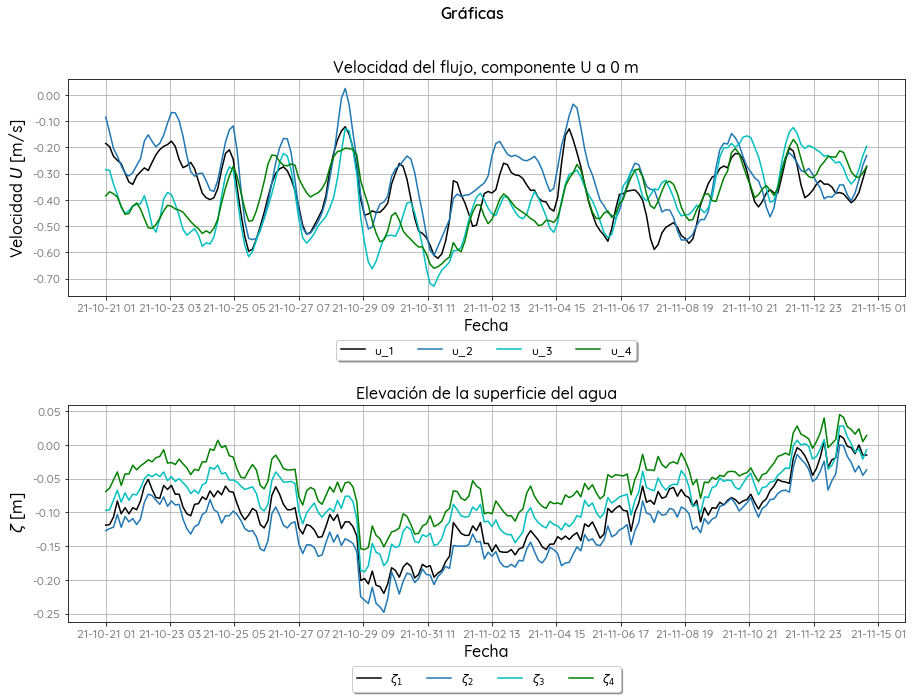

In [ ]:
hourticks = ((time_d3d[-1]-time_d3d[0]).days*24 +(time_d3d[-1]-time_d3d[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, axs = plt.subplots(2,1,figsize=(15,10))
ax = axs[0]
ax.plot(time_d3d, u_1[:,2], label = 'u_1', ms=5, color = 'k')
ax.plot(time_d3d, u_2[:,2], label = 'u_2', ms=5)
ax.plot(time_d3d, u_3[:,2], label = 'u_3', ms=5, color = 'c')
ax.plot(time_d3d, u_4[:,2], label = 'u_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('Velocidad $U$ [m/s]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Velocidad del flujo, componente U a 0 m',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

ax1 = axs[1]

ax1.plot(time_d3d, ws_1, label = '$\zeta_1$', ms=5, color = 'k')
ax1.plot(time_d3d, ws_2, label = '$\zeta_2$', ms=5)
ax1.plot(time_d3d, ws_3, label = '$\zeta_3$', ms=5, color = 'c')
ax1.plot(time_d3d, ws_4, label = '$\zeta_4$', ms=5,color = 'green')
ax1.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax1.set_ylabel (' $\zeta$ [m]',size=16,fontproperties=prop1)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Elevación de la superficie del agua',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=0)
ax1.grid(True)
plt.subplots_adjust(hspace=0.5)
#      left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
                    
# ax.set_title('Velocidad superficial',size=15)
# plt.savefig('E:/Escritorio/INFORME 1ER AÑO UNAL/Anexo_B1/velocidad_2D.png',dpi=800,bbox_inches='tight',pad_inches=0)

## Estructura de RIEMANN

In [ ]:
ind_min_lon_bd = np.where((x_bd[0] <= x_new + delta) & (x_bd[0] >= x_new - delta))[0]
ind_max_lon_bd = np.where((x_bd[1] <= x_new + delta) & (x_bd[1] >= x_new - delta))[0]
ind_min_lat_bd = np.where((y_bd[0] <= y_new + delta) & (y_bd[0] >= y_new - delta))[0]
ind_max_lat_bd = np.where((y_bd[1] <= y_new + delta) & (y_bd[1] >= y_new - delta))[0]

# Proceso para elegir el índice que más se ajusta a los puntos de bd
# Imprime los indíces más cercanos a bd en las pocisiones cardinales
print(ind_min_lon_bd,'\n', ind_max_lon_bd)
print(ind_min_lat_bd,'\n', ind_max_lat_bd)
print('\n')

# Imprime las pocisiones cardinales acopladas a la batimetría
print(x_new[ind_min_lon_bd],'\n', x_new[ind_max_lon_bd])
print(y_new[ind_min_lat_bd],'\n', y_new[ind_max_lat_bd])
print('\n')

# Imprime las diferencias entre las coordenadas de los puntos de bd y de la batimetría
print(abs(x_new[ind_min_lon_bd[0]]-x_bd[0]),abs(x_new[ind_min_lon_bd[1]]-x_bd[0]),'\n', abs(x_new[ind_max_lon_bd[0]]-x_bd[1]),abs(x_new[ind_max_lon_bd[1]]-x_bd[1]))
print(abs(y_new[ind_min_lat_bd[0]]-y_bd[0]),abs(y_new[ind_min_lat_bd[1]]-y_bd[0]),'\n', abs(y_new[ind_max_lat_bd[0]]-y_bd[1]),abs(y_new[ind_max_lat_bd[1]]-y_bd[1]))

[19 20] 
 [193 194]
[12 13] 
 [189 190]


[408558.9787 408758.9787] 
 [443358.9787 443558.9787]
[1370754.4849 1370954.4849] 
 [1406154.4849 1406354.4849]


137.14987255667802 62.85012744332198 
 116.2953317896463 83.7046682103537
174.68503128085285 25.314968719147146 
 164.64118160516955 35.35881839483045


In [ ]:
# Con base en las mínimas diferencias se elige los indices respectivos a las coordenadas de la batimetría
ind_min_lon_bd = np.where((x_bd[0] <= x_new + delta) & (x_bd[0] >= x_new - delta))[0][1]
ind_max_lon_bd = np.where((x_bd[1] <= x_new + delta) & (x_bd[1] >= x_new - delta))[0][1]
ind_min_lat_bd = np.where((y_bd[0] <= y_new + delta) & (y_bd[0] >= y_new - delta))[0][1]
ind_max_lat_bd = np.where((y_bd[1] <= y_new + delta) & (y_bd[1] >= y_new - delta))[0][1]

In [ ]:
# profundidades de los puntos elegidos
depth_1 = z_new[ind_min_lat_bd,ind_min_lon_bd] 
depth_2 = z_new[ind_min_lat_bd,ind_max_lon_bd]
depth_3 = z_new[ind_max_lat_bd,ind_max_lon_bd]
depth_4 = z_new[ind_max_lat_bd,ind_min_lon_bd]
print(depth_1, depth_2, depth_3, depth_4)

1702.529 948.2702 1013.064 937.7902


### Riemann equation requirement

$$f(t)=U+\zeta\sqrt{\frac{g}{d}}$$

In [ ]:
g = 9.81 # m/s^2

# Aplicación de la ecuación insumo de Riemann
# En la frontera OESTE
ft_west_a = np.zeros(shape=(u_1.shape))
ft_west_b = np.zeros(shape=(u_4.shape))
ft_south_b = np.zeros(shape=(u_2.shape))
ft_east_b = np.zeros(shape=(u_3.shape))
for i,j in enumerate(depth):
    ft_west_a[:,i] = u_1[:,i] + ws_1*np.sqrt(g/depth_1)
    ft_west_b[:,i] = u_4[:,i] + ws_4*np.sqrt(g/depth_4)
    ft_south_b[:,i] = u_2[:,i] + ws_2*np.sqrt(g/depth_2)
    ft_east_b[:,i] = u_3[:,i] + ws_3*np.sqrt(g/depth_3)
    print('Depth ',j, i)
# En la frontera SUR
ft_south_a = ft_west_a


# En la frontera Este
ft_east_a = ft_south_b


# En la frontera Norte
ft_north_a = ft_west_b
ft_north_b = ft_east_b

print(ft_north_a.shape)

Depth  0.0 0
Depth  2.0 1
Depth  4.0 2
Depth  6.0 3
Depth  8.0 4
Depth  10.0 5
Depth  12.0 6
Depth  15.0 7
Depth  20.0 8
(198, 9)


#### Archivos txt

**NOTA:** Los archivos btc se deben unir en un archivo madre que contiene todas las condiciones de borde, y la información 

In [ ]:
print(time_d3d[0])
print(time_d3d[-1])
print(len(time_d3d))
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
data = {'minutes':minutes,'A_0':ft_east_a[:,0],'A_2':ft_east_a[:,2],'A_3':ft_east_a[:,4],'A_4':ft_east_a[:,6],'A_5':ft_east_a[:,8],'B_0':ft_east_b[:,0],'B_2':ft_east_b[:,2],\
       'B_3':ft_east_b[:,4], 'B_4':ft_east_b[:,6], 'B_5':ft_east_b[:,8]}
data = {'minutes':minutes,'A_0':ft_east_a[:,0],'A_2':ft_east_a[:,2],'A_3':ft_east_a[:,4],'B_0':ft_east_b[:,0],'B_2':ft_east_b[:,2],\
       'B_3':ft_east_b[:,4]}
df = pd.DataFrame(data)
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'east_boundary.bct'
np.savetxt(path+'/'+name_file, df.values, delimiter=' ', fmt = "%+15.7e")
df

2021-10-21 01:00:00
2021-11-14 16:00:00
198


,minutes,A_0,A_2,A_3,B_0,B_2,B_3
0,0.0,-0.093917,-0.096917,-0.100917,-0.305545,-0.294545,-0.295545
1,180.0,-0.165612,-0.154612,-0.154612,-0.309447,-0.297447,-0.294447
2,360.0,-0.207409,-0.216409,-0.219409,-0.347069,-0.348069,-0.349069
3,540.0,-0.207476,-0.243476,-0.246476,-0.374593,-0.386593,-0.387593
4,720.0,-0.242409,-0.281409,-0.289409,-0.440364,-0.437364,-0.437364
...,...,...,...,...,...,...,...
193,34740.0,-0.428645,-0.405645,-0.395645,-0.366803,-0.339803,-0.327803
194,34920.0,-0.390068,-0.378068,-0.373068,-0.347082,-0.324082,-0.314082
195,35100.0,-0.362153,-0.327153,-0.305153,-0.318590,-0.284590,-0.255590
196,35280.0,-0.333577,-0.272577,-0.238577,-0.284067,-0.234067,-0.191067


In [ ]:
# print(time_d3d[0])
# print(time_d3d[-1])
# print(len(time_d3d))
# minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
# data = {'minutes':minutes,'A_0':ft_west_a[:,0],'A_2':ft_west_a[:,1],'A_4':ft_west_a[:,2], 'A_6':ft_west_a[:,3],'B_0':ft_west_b[:,0],'B_2':ft_west_b[:,1],\
#        'B_4':ft_west_b[:,2],'B_6':ft_west_b[:,3]}
# df = pd.DataFrame(data)
# path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
# name_file = 'west_boundary.bct'
# np.savetxt(path+'/'+name_file, df.values, delimiter='  ', fmt = "%.7e" )
# df

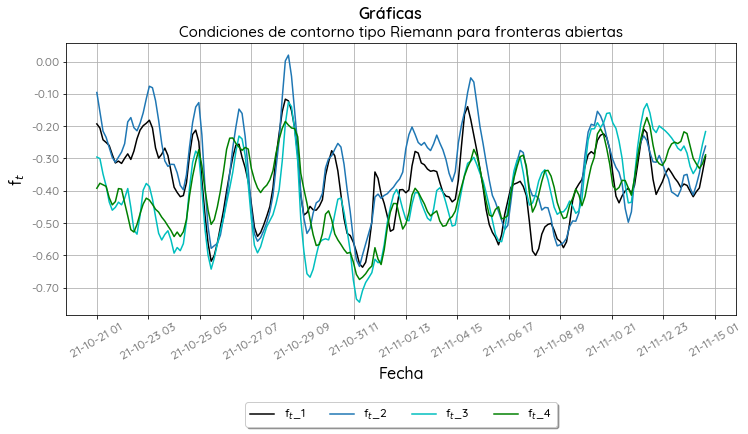

In [ ]:
hourticks = ((time_d3d[-1]-time_d3d[0]).days*24 +(time_d3d[-1]-time_d3d[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(time_d3d, ft_west_a[:,1], label = 'f$_t$_1', ms=5, color = 'k')
ax.plot(time_d3d, ft_south_b[:,1], label = 'f$_t$_2', ms=5)
ax.plot(time_d3d, ft_east_b[:,1], label = 'f$_t$_3', ms=5, color = 'c')
ax.plot(time_d3d, ft_north_a[:,1], label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('f$_t$',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Condiciones de contorno tipo Riemann para fronteras abiertas',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

## Propiedades constitutivas 

In [ ]:
salt_1 = salt[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_min_lon]
salt_2 = salt[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_max_lon]
salt_3 = salt[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_max_lon]
salt_4 = salt[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_min_lon]
temp_1 = temp[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_min_lon]
temp_2 = temp[ind_ini_fin[0]:ind_ini_fin[1],:,ind_min_lat,ind_max_lon]
temp_3 = temp[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_max_lon]
temp_4 = temp[ind_ini_fin[0]:ind_ini_fin[1],:,ind_max_lat,ind_min_lon]

In [ ]:
salt_1.shape

(198, 9)

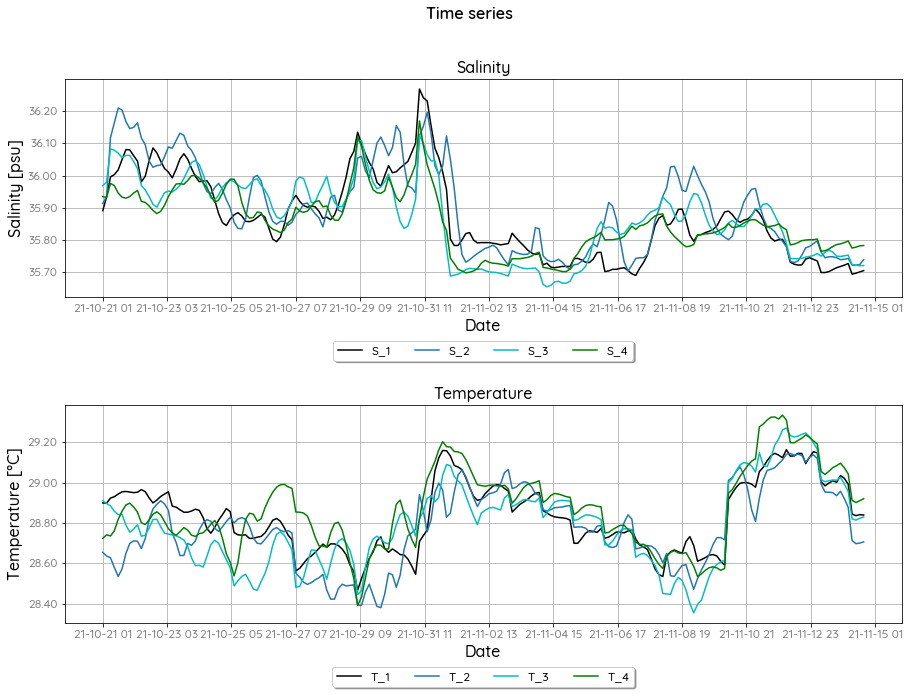

In [ ]:
hourticks = ((time_d3d[-1]-time_d3d[0]).days*24 +(time_d3d[-1]-time_d3d[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, axs = plt.subplots(2,1,figsize=(15,10))
ax = axs[0]
ax.plot(time_d3d, salt_1[:,8], label = 'S_1', ms=5, color = 'k')
ax.plot(time_d3d, salt_2[:,8], label = 'S_2', ms=5)
ax.plot(time_d3d, salt_3[:,8], label = 'S_3', ms=5, color = 'c')
ax.plot(time_d3d, salt_4[:,8], label = 'S_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Date',size=16,fontproperties=prop1)
ax.set_ylabel ('Salinity [psu]',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Time series", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Salinity',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

ax1 = axs[1]

ax1.plot(time_d3d, temp_1[:,8], label = 'T_1', ms=5, color = 'k')
ax1.plot(time_d3d, temp_2[:,8], label = 'T_2', ms=5)
ax1.plot(time_d3d, temp_3[:,8], label = 'T_3', ms=5, color = 'c')
ax1.plot(time_d3d, temp_4[:,8], label = 'T_4', ms=5,color = 'green')
ax1.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax1.xaxis.set_major_formatter(date_format)
ax1.set_xlabel ('Date',size=16,fontproperties=prop1)
ax1.set_ylabel ('Temperature [°C]',size=16,fontproperties=prop1)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax1.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_title('Temperature',size = 16,fontproperties=prop1)   # Subtítulo de la figura
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.175),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=0)
ax1.grid(True)
plt.subplots_adjust(hspace=0.5)
#      left=0.125,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
                    
# ax.set_title('Velocidad superficial',size=15)
# plt.savefig('E:/Escritorio/INFORME 1ER AÑO UNAL/Anexo_B1/velocidad_2D.png',dpi=800,bbox_inches='tight',pad_inches=0)

In [ ]:
sal_south_a = salt_1 ; temp_south_a = temp_1
sal_south_b = salt_2 ; temp_south_b = temp_2
sal_north_a = salt_4 ; temp_north_a = temp_4
sal_north_b = salt_3 ; temp_north_b = temp_3
sal_west_a = salt_1 ; temp_west_a = temp_1
sal_west_b = salt_4 ; temp_west_b = temp_4
sal_east_a = salt_2 ; temp_east_a = temp_2
sal_east_b = salt_3 ; temp_east_b = temp_3

In [ ]:
print(time_d3d[0])
print(time_d3d[-1])
print(len(time_d3d))
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
data = {'minutes':minutes,'A_0':sal_west_a[:,0],'A_2':sal_west_a[:,2],'A_3':sal_west_a[:,4],'A_4':sal_west_a[:,6],'A_5':sal_west_a[:,8],'B_0':sal_west_b[:,0],'B_2':sal_west_b[:,2],\
       'B_3':sal_west_b[:,4], 'B_4':sal_west_b[:,6], 'B_5':sal_west_b[:,8]}
data = {'minutes':minutes,'A_0':sal_west_a[:,0],'A_2':sal_west_a[:,2],'A_3':sal_west_a[:,4],'B_0':sal_west_b[:,0],'B_2':sal_west_b[:,2],\
       'B_3':sal_west_b[:,4]}
df = pd.DataFrame(data)
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_west_boundary.bcc'
np.savetxt(path+'/'+name_file, df.values, delimiter=' ', fmt = "%+15.7e")
df

2021-10-21 01:00:00
2021-11-14 16:00:00
198


,minutes,A_0,A_2,A_3,B_0,B_2,B_3
0,0.0,35.829001,35.830001,35.831001,35.777001,35.773001,35.774001
1,180.0,35.833001,35.834001,35.834001,35.773001,35.768001,35.769001
2,360.0,35.886001,35.887001,35.888001,35.808001,35.809001,35.810001
3,540.0,35.894001,35.897001,35.898001,35.809001,35.812001,35.813001
4,720.0,35.898001,35.907001,35.908001,35.805001,35.814001,35.815001
...,...,...,...,...,...,...,...
193,34740.0,35.723001,35.723001,35.723001,35.792001,35.793001,35.793001
194,34920.0,35.687001,35.687001,35.688001,35.756001,35.755001,35.757001
195,35100.0,35.693001,35.692001,35.692001,35.759001,35.760001,35.762001
196,35280.0,35.697001,35.696001,35.695001,35.757001,35.759001,35.762001


In [ ]:
print(time_d3d[0])
print(time_d3d[-1])
print(len(time_d3d))
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
data = {'minutes':minutes,'A_0':sal_east_a[:,0],'A_2':sal_east_a[:,1],'A_4':sal_east_a[:,2], 'A_6':sal_east_a[:,3],'B_0':sal_east_b[:,0],'B_2':sal_east_b[:,1],\
       'B_4':sal_east_b[:,2],'B_6':sal_east_b[:,3]}
df = pd.DataFrame(data)
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_east_boundary.bcc'
np.savetxt(path+'/'+name_file, df.values, delimiter='  ', fmt = ['%.1f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f'] )
df

2021-10-21 01:00:00
2021-11-14 16:00:00
198


,minutes,A_0,A_2,A_4,A_6,B_0,B_2,B_4,B_6
0,0.0,35.535001,35.537001,35.537001,35.538001,35.850001,35.847001,35.848001,35.848001
1,180.0,35.541001,35.544001,35.544001,35.544001,35.849001,35.848001,35.848001,35.848001
2,360.0,35.715001,35.719001,35.719001,35.719001,35.965001,35.964001,35.964001,35.965001
3,540.0,35.728001,35.727001,35.728001,35.728001,35.952001,35.964001,35.965001,35.966001
4,720.0,35.741001,35.738001,35.738001,35.739001,35.929001,35.963001,35.965001,35.966001
...,...,...,...,...,...,...,...,...,...
193,34740.0,35.740001,35.739001,35.739001,35.739001,35.747001,35.747001,35.747001,35.747001
194,34920.0,35.716001,35.715001,35.715001,35.715001,35.715001,35.715001,35.715001,35.715001
195,35100.0,35.719001,35.719001,35.719001,35.719001,35.714001,35.715001,35.715001,35.715001
196,35280.0,35.720001,35.721001,35.721001,35.722001,35.713001,35.713001,35.714001,35.714001


In [ ]:
print(time_d3d[0])
print(time_d3d[-1])
print(len(time_d3d))
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
# data = {'minutes':minutes,'A_0':temp_east_a[:,0],'A_2':temp_east_a[:,1],'A_4':temp_east_a[:,2],'B_0':temp_east_b[:,0],'B_2':temp_east_b[:,1],\
#        'B_4':temp_east_b[:,2]}
data = {'minutes':minutes,'A_0':temp_east_a[:,0],'A_2':temp_east_a[:,2],'A_3':temp_east_a[:,4],'A_4':temp_east_a[:,6],'A_5':temp_east_a[:,8],'B_0':temp_east_b[:,0],'B_2':temp_east_b[:,2],\
       'B_3':temp_east_b[:,4], 'B_4':temp_east_b[:,6], 'B_5':temp_east_b[:,8]}
data = {'minutes':minutes,'A_0':temp_east_a[:,0],'A_2':temp_east_a[:,2],'A_3':temp_east_a[:,4],'B_0':temp_east_b[:,0],'B_2':temp_east_b[:,2],\
       'B_3':temp_east_b[:,4]}
df = pd.DataFrame(data)
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'tempt_east_boundary.bcc'
np.savetxt(path+'/'+name_file, df.values, delimiter=' ', fmt = "%+15.7e")
df

2021-10-21 01:00:00
2021-11-14 16:00:00
198


,minutes,A_0,A_2,A_3,B_0,B_2,B_3
0,0.0,29.033,28.987,28.998,29.089,29.042,29.055
1,180.0,28.998,28.949,28.962,29.054,29.031,29.034
2,360.0,29.092,29.025,29.028,29.095,29.061,29.064
3,540.0,29.096,29.026,29.025,29.182,29.094,29.091
4,720.0,29.353,29.049,29.035,29.591,29.151,29.132
...,...,...,...,...,...,...,...
193,34740.0,28.951,28.851,28.860,28.954,28.966,28.965
194,34920.0,28.780,28.674,28.684,28.805,28.817,28.817
195,35100.0,28.726,28.704,28.690,28.851,28.833,28.817
196,35280.0,28.956,28.779,28.721,29.010,28.930,28.864


In [ ]:
print(time_d3d[0])
print(time_d3d[-1])
print(len(time_d3d))
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
data = {'minutes':minutes,'A_0':temp_south_a[:,0],'A_2':temp_south_a[:,1],'A_4':temp_south_a[:,2], 'A_6':temp_south_a[:,3],'B_0':temp_south_b[:,0],'B_2':temp_south_b[:,1],\
       'B_4':temp_south_b[:,2],'B_6':temp_south_b[:,3]}
df = pd.DataFrame(data)
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'tempt_south_boundary.bcc'
np.savetxt(path+'/'+name_file, df.values, delimiter='  ', fmt = ['%.1f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f','%.6f'] )
df

2021-10-21 01:00:00
2021-11-14 16:00:00
198


,minutes,A_0,A_2,A_4,A_6,B_0,B_2,B_4,B_6
0,0.0,28.927,28.867,28.880,28.887,29.033,28.974,28.987,28.995
1,180.0,28.921,28.855,28.863,28.868,28.998,28.939,28.949,28.958
2,360.0,28.967,28.885,28.890,28.894,29.092,29.020,29.025,29.028
3,540.0,29.106,28.928,28.914,28.911,29.096,29.041,29.026,29.025
4,720.0,29.600,29.026,28.965,28.946,29.353,29.095,29.049,29.038
...,...,...,...,...,...,...,...,...,...
193,34740.0,29.014,28.991,28.996,28.998,28.951,28.842,28.851,28.856
194,34920.0,28.852,28.826,28.830,28.833,28.780,28.665,28.674,28.679
195,35100.0,28.876,28.869,28.853,28.842,28.726,28.720,28.704,28.693
196,35280.0,29.031,28.980,28.940,28.904,28.956,28.835,28.779,28.737


- Para una dimension

In [ ]:

# # Función para extraer archivos Rieman 
# def file_riemann2D (time_d3d,ft_a, ft_b, path, name_file):
#     """
#     Inputs:
#     - time_d3d: Cantidad de tiempo a simular
#     - ft_a: Serie Riemman en el punto a
#     - ft_b: Serie Riemman en el punto b
#     - path: path
#     - name_file: name of file
#     ------------------------------------------------------------------------------------
#     Outpust:
    
#     fileof Riemann condition
    
#     """
#     print(time_d3d[0])
#     print(time_d3d[-1])
#     print(len(time_d3d))
#     minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])
#     data = {'minutes':minutes,'A':ft_a,'B':ft_b}
#     df = pd.DataFrame(data)
#     np.savetxt(path+'/'+name_file, df.values, delimiter='  ', fmt = ['%.1f','%.6f','%.6f'] ) 
#     return df

In [ ]:
# path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION"
# name_file = 'rieman_condition_south.bct'
# file_east = file_riemann2D(time_d3d,ft_south_a,ft_south_b,path,name_file)

# PARÁMETROS FÍSICOS 

Please note that the ERA5 native grid of online CDS is 0.25°x0.25° (atmosphere), 0.5°x0.5° (ocean waves), mean, spread and members: 0.5°x0.5° (atmosphere), 1°x1° (ocean waves). ERA5-Land: 0.1°x0.1°. So this will be returned by default.

https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5#HowtodownloadERA5-4-DownloadERA5familydatathroughtheCDSAPI

Se descargan los datos de la base de datos ERA 5

Descargar Api: https://cds.climate.copernicus.eu/api-how-to

In [ ]:
print(min_lon,max_lon)
print(max_lat-min_lat)

278.1600341796875 278.47998046875
0.32000064849853516


In [ ]:
# %%time
# # Descargar datos de ERA5
# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-single-levels',
#     {
#         'product_type': 'reanalysis',
#         'format': 'netcdf',
#         'variable': [
#             '10m_u_component_of_wind', '10m_v_component_of_wind',
#         ],
#         'year': [
#              '2021',
#         ],
#         'month': [
            
#             '10', '11',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': [
#             '00:00', '01:00', '02:00',
#             '03:00', '04:00', '05:00',
#             '06:00', '07:00', '08:00',
#             '09:00', '10:00', '11:00',
#             '12:00', '13:00', '14:00',
#             '15:00', '16:00', '17:00',
#             '18:00', '19:00', '20:00',
#             '21:00', '22:00', '23:00',
#         ],
#         'area':[
#             '12.75','278.160','12.40','278.51',
#         ],
#         'grid':[
#             '0.17','0.17',
#         ],
#     },
#     'data_wind_2021_oct_nov.nc')

In [ ]:
data = Dataset('data_wind_2021_oct_nov.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (3,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (3,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'u10': <class 'netCDF4._netCDF4.Variable'>
 int16 u10(time, latitude, longitude)
     scale_factor: 0.00017696378961697313
     add_offset: -4.378664596668559
     _FillValue: -32767
     missing_value: -32767
     units: m s**-1
     long_name: 10 metre U wind com

In [ ]:
# Extraer variables
lat_wind = np.array(data.variables['latitude'][:])
lon_wind = np.array(data.variables['longitude'][:])
nctime_wind = np.array(data.variables['time'][:])
t_unit_wind = data.variables['time'].units
t_cal_wind = data.variables['time'].calendar
time_wind = num2date(nctime_wind,units=t_unit_wind,calendar=t_cal_wind)#Date time
u10_wind = np.array(data.variables['u10'][:])
v10_wind = np.array(data.variables['v10'][:])

# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wind])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time_wind = np.array([datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time_wind

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

In [ ]:
# Función para determinar 
def angulo_norte(x,y):
    if x > 0 and y > 0:
        theta = 90 - (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y > 0:
        theta = 270 + (np.arctan(abs(y/x))*(180/np.pi))
    elif x < 0 and y < 0:
        theta = 270 - (np.arctan(abs(y/x))*(180/np.pi))
    else:
        theta = 90 + (np.arctan(abs(y/x))*(180/np.pi))
    return theta

In [ ]:
date_ini = datetime(2021,10,29,0) # Parámetro a variar
date_fin = datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time_wind==date_ini)|(time_wind==date_fin))[0]
time_d3d_wind = time_wind[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wind.shape)

[ 677 1077]
(400,)


In [ ]:
time_d3d_wind 

array([datetime.datetime(2021, 10, 29, 0, 0),
       datetime.datetime(2021, 10, 29, 1, 0),
       datetime.datetime(2021, 10, 29, 2, 0),
       datetime.datetime(2021, 10, 29, 3, 0),
       datetime.datetime(2021, 10, 29, 4, 0),
       datetime.datetime(2021, 10, 29, 5, 0),
       datetime.datetime(2021, 10, 29, 6, 0),
       datetime.datetime(2021, 10, 29, 7, 0),
       datetime.datetime(2021, 10, 29, 8, 0),
       datetime.datetime(2021, 10, 29, 9, 0),
       datetime.datetime(2021, 10, 29, 10, 0),
       datetime.datetime(2021, 10, 29, 11, 0),
       datetime.datetime(2021, 10, 29, 12, 0),
       datetime.datetime(2021, 10, 29, 13, 0),
       datetime.datetime(2021, 10, 29, 14, 0),
       datetime.datetime(2021, 10, 29, 15, 0),
       datetime.datetime(2021, 10, 29, 16, 0),
       datetime.datetime(2021, 10, 29, 17, 0),
       datetime.datetime(2021, 10, 29, 18, 0),
       datetime.datetime(2021, 10, 29, 19, 0),
       datetime.datetime(2021, 10, 29, 20, 0),
       datetime.datetim

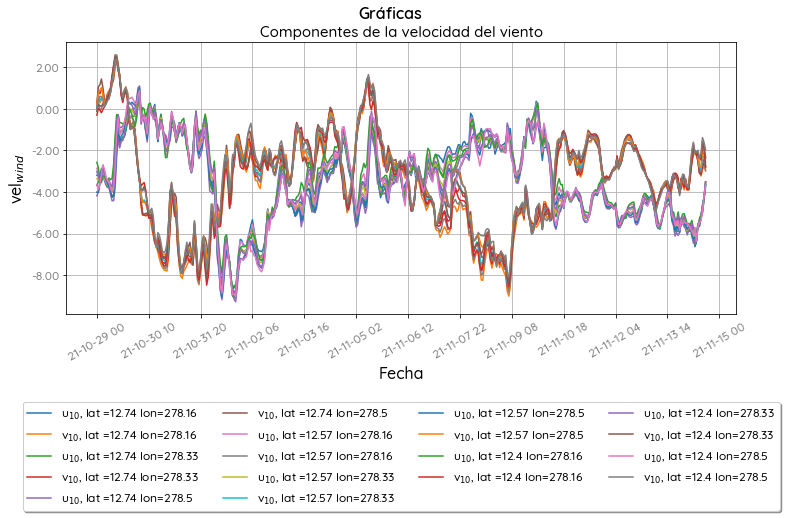

In [ ]:
hourticks = ((time_d3d_wind[-1]-time_d3d_wind[0]).days*24 +(time_d3d_wind[-1]-time_d3d_wind[0]).seconds/3600+12) # Mover parámetro 12
xticks_time = np.array([time_d3d_wind[0] + timedelta(hours=h) for h in range(0,int(hourticks),int(hourticks/12))]) # Mover parámetro 12

fig, ax = plt.subplots(figsize=(12,5))
for i in range(len(lat_wind)):
    for j in range(len(lon_wind)):
        ax.plot(time_d3d_wind, u10_wind[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'u$_{10}$, lat ='+str(lat_wind[i])+ ' lon='+str(lon_wind[j]))
        ax.plot(time_d3d_wind, v10_wind[ind_ini_fin[0]:ind_ini_fin[1],i,j], label = 'v$_{10}$, lat ='+str(lat_wind[i])+ ' lon='+str(lon_wind[j]))

# ax.plot(time_d3d, ft_west_a, label = 'f$_t$_1', ms=5, color = 'k')
# ax.plot(time_d3d, ft_south_b, label = 'f$_t$_2', ms=5)
# ax.plot(time_d3d, ft_east_b, label = 'f$_t$_3', ms=5, color = 'c')
# ax.plot(time_d3d, ft_north_a, label = 'f$_t$_4', ms=5,color = 'green')
ax.set_xticks(xticks_time)
date_format = mdates.DateFormatter('%y-%m-%d %H')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel ('Fecha',size=16,fontproperties=prop1)
ax.set_ylabel ('vel$_{wind}$',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
for label in ax.get_xticklabels():
    label.set_fontproperties(prop1)
    label.set_color('gray')
    label.set_size(12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.suptitle("Gráficas", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Componentes de la velocidad del viento',size = 15,fontproperties=prop1)   # Subtítulo de la figura
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation=30)
ax.grid(True)

In [ ]:
x_wind_utm = np.zeros(shape=(lon_wind.shape))
y_wind_utm = np.zeros(shape=(lat_wind.shape))
m = 0 
for i, j in zip (lon_wind,lat_wind):
    x_wind_utm[m],y_wind_utm[m]= proj_ZONE17(i,j)
    m = m + 1
    

## Generar archivo txt

In [ ]:
# Extraer componentes de la velocidad el viento para la fecha establecida y calcular la magnitud y direeción de los vientos.
vd3d_wind = v10_wind[ind_ini_fin[0]:ind_ini_fin[1],0,0]
ud3d_wind = u10_wind[ind_ini_fin[0]:ind_ini_fin[1],0,0]
Wind_magnitud = np.sqrt(vd3d_wind**2+ud3d_wind**2)
Wind_dir = np.array([angulo_norte(ud3d_wind[i],vd3d_wind[i]) for i in range (0, len(vd3d_wind))])

In [ ]:
minutes = np.array([((time_d3d_wind[i] - time_d3d_wind[0]).days*1440)+((time_d3d_wind[i] - time_d3d_wind[0]).seconds/60) for i in range (0,len(time_d3d_wind))])
data_wind = {'minutes':minutes,'wind_speed':Wind_magnitud,'wind_dir':Wind_dir}
df_wind = pd.DataFrame(data = data_wind)

In [ ]:
# path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION"
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
file_name = 'data_wind.wnd'
np.savetxt(path+'/'+file_name, df_wind.values, delimiter='  ', fmt = "%.7f" ) 

# CONTOURF INPUTS

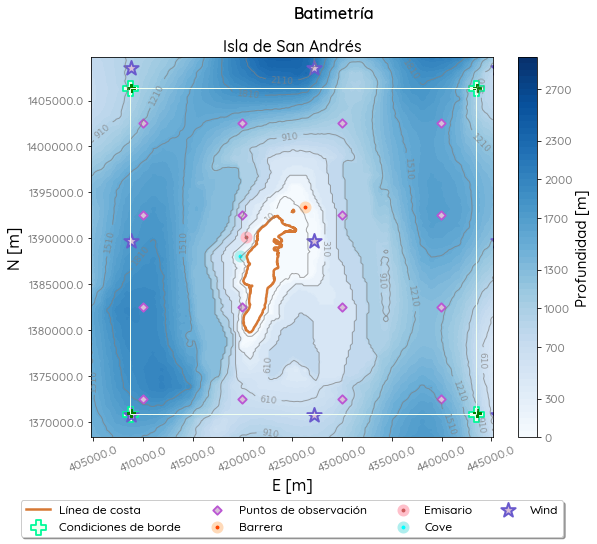

In [ ]:
# Figura con todo
X_WIND, Y_WIND = np.meshgrid(x_wind_utm, y_wind_utm)
X_BD, Y_BD = np.meshgrid(x_bd,y_bd)
X_control, Y_control = np.meshgrid(x_control, y_control) 
# crear figura
# ------------
fig, ax = plt.subplots(figsize = (9,7))
colormap = cm.YlGnBu
colormap = cm.Blues
level_i = 0
level_f = 3000
pc = ax.contourf(x_new, y_new, z_new,levels = np.arange(level_i,level_f,50),cmap=colormap)
cb=plt.colorbar(pc,ticks = list(roundBy(np.linspace(level_i,level_f,10)[i],100) for i in range(10)))
a = ax.contour(x_new, y_new, z_new,levels=list(np.arange(10,3000,300)),colors="gray",\
               linewidths=1,alpha=0.7)
label_fig = ax.clabel(a, fontsize=9, inline=1, fmt = '%1.0f', colors="gray")
# plt.clabel(a, fontsize=9, inline=1,fmt='%2.1f',colors='k')
ax.set_xlabel ('E [m]',size=16,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=16,fontproperties=prop1)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Profundidad [m]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=12)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
fig.suptitle("Batimetría", size = 16,fontproperties=prop2)     # Titulo de la figura
ax.set_title('Isla de San Andrés',size = 16,fontproperties=prop1)   # Subtítulo de la figura
# for label in ax.get_xticklabels():
#     label.set_fontproperties(prop_1)
#     label.set_color('gray')
#     label.set_size(12)
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', label = 'Línea de costa',  lw=2.5, alpha = 0.9)
ax.scatter(X_BD,Y_BD,marker='P',color='mediumspringgreen',label='Condiciones de borde',s=15**2\
          ,facecolors= 'honeydew',lw=1.8)
ax.scatter(X_control,Y_control,marker='D',color='mediumorchid',label='Puntos de observación',s=6**2\
          ,facecolors= 'thistle',lw=1.8)
ax.scatter(x_barrera,y_barrera,marker='o',color='peachpuff',label='Barrera',s=8**2 ,facecolors= 'orangered',lw=4)
ax.scatter(x_emisario,y_emisario,marker='o',color='pink',label='Emisario',s=8**2 ,facecolors= 'indianred',lw=4)
ax.scatter(x_cove,y_cove,marker='o',color='paleturquoise',label='Cove',s=8**2,facecolors= 'cyan',lw=4)
ax.scatter(X_WIND, Y_WIND,marker='*',color= 'slateblue',label='Wind',s=15**2,facecolors= 'thistle',lw=2)


ax.scatter(x_new[ind_min_lon_bd],y_new[ind_min_lat_bd],marker = 'P', s = 8**2, color = 'green') 
ax.scatter(x_new[ind_max_lon_bd],y_new[ind_min_lat_bd],marker = 'P', s = 8**2, color = 'green')
ax.scatter(x_new[ind_max_lon_bd],y_new[ind_max_lat_bd],marker = 'P', s = 8**2, color = 'green')
ax.scatter(x_new[ind_min_lon_bd],y_new[ind_max_lat_bd],marker = 'P', s = 8**2, color = 'green')

ax.hlines(y_bd,x_bd.min(),x_bd.max(),colors='honeydew',linestyles='-',lw=1)
ax.vlines(x_bd,y_bd.min(),y_bd.max(),colors='honeydew',linestyles='-',lw=1)

prop1.set_size(12) # Aumentar el tamaño de letra de la leyenda
_= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
plt.xticks(rotation =22.5)
plt.grid(False)

# OPEN HYCOM DATA

On the web page, https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0.html, write the specific lat, long, time, and depth indices where include the data to SAI. To generate netcdf file run a matlab code whit name **'HYCOM_TO_NETCDF_FILE_V2.mlx'**

In [ ]:
data = Dataset('Hycom_oct21_nov15_2021_6.nc','r')
data.variables

{'latitude': <class 'netCDF4._netCDF4.Variable'>
 float64 latitude(latitude)
     units: decimal_degrees
 unlimited dimensions: 
 current shape = (25,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'longitude': <class 'netCDF4._netCDF4.Variable'>
 float64 longitude(longitude)
     units: decimal_degrees
 unlimited dimensions: 
 current shape = (7,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 float64 time(time)
     units: hours since 2000-01-01 00:00:00
     time_origin: 2000-01-01 00:00:00
     calendar: gregorian
 unlimited dimensions: 
 current shape = (200,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'depth': <class 'netCDF4._netCDF4.Variable'>
 float64 depth(depth)
     units: m
 unlimited dimensions: 
 current shape = (9,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'water_temp': <class 'netCDF4._netCDF4.Variable'>
 float64 water_temp(time, depth, latitude, 

In [ ]:
%%time
lat = np.array(data.variables['latitude'][:])
lon = np.array(data.variables['longitude'][:])
nctime = np.array(data.variables['time'][:])
t_unit = data.variables['time'].units
t_cal = data.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])
depth = np.array(data.variables['depth'][:]) 
salt = np.array(data.variables['salinity'][:])
salt[salt==-30000] = np.nan
temp = np.array(data.variables['water_temp'][:])
temp[temp==-30000] = np.nan
u = np.array(data.variables['water_u'][:])
u[u==-30000] = np.nan
v = np.array(data.variables['water_v'][:])
v[v==-30000] = np.nan
ws = np.array(data.variables['surf_el'][:])

Wall time: 58.9 ms


# RESULTADOS

In [ ]:
data_results = Dataset('trih_TEST3_MDF.nc','r')
print(data_results.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1970-01-01 00:00:00 -05:00
    axis: T
    actual_range: 2021-10-21 01:00:00	2021-11-14 15:00:00
unlimited dimensions: 
current shape = (3541,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'platform_name': <class 'netCDF4._netCDF4.Variable'>
|S1 platform_name(Station, platform_name_len)
    standard_name: platform_name
    long_name: Name of monitoring station
    delft3d_name: NAMST
    cf_role: timeseries_id
unlimited dimensions: 
current shape = (19, 20)
filling on, default _FillValue of   used, 'platform_m_index': <class 'netCDF4._netCDF4.Variable'>
float32 platform_m_index(Station)
    long_name: Delft3D-FLOW m index of station
    units: 1
    delft3d_name: MNSTAT
    _FillValue: nan
    actual_range: [ 26. 176.]
unlimited dimensions: 
current shape = (19,)
filling on, 'platform_n_index': <class 'netCDF4._netCDF4.Variable'>
float32 pla